# Imports and overview

This notebook implements the CORAL model from https://arxiv.org/pdf/1511.05547.pdf. It is inspired from https://github.com/SSARCandy/DeepCORAL.

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchmetrics
import os
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from IPython.display import clear_output

# Clear the cache of CUDA
torch.cuda.empty_cache()

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

For reference, here is the architecture of the model we will implement:

<img src="CORAL_architecture.png" align="center"/>

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once.

In [3]:
# Transform to apply to the minibatches for data augmentation
# Define the transformation to apply
# Transformations: Random horizontal and vertical flips, halving and doubling the brightness
# This should improve the prediction accuracy
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=[0.75, 1.25])], p=0.5)
])

class CustomDataset(Dataset):
    
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.images = os.listdir(root_dir)
        self.labels = torch.load(label_dir).long()

        # Remove the labels that do not belong to this split of the dataset (Labels is all labels)
        self.labels = self.labels[torch.tensor([int(img_name[3:9]) for img_name in self.images])]



    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        image = transform(image)
        label = self.labels[idx] # Since we removed the labels that do not belong to this split, we can use idx directly
        return image, label

# Extract the generated data
generated_data_root = "../../Data Generation/Pre Processed Data Generated"
train_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Training", generated_data_root + "/Square Images/y_generated.pt")
val_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Validation", generated_data_root + "/Square Images/y_generated.pt")
test_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Testing", generated_data_root + "/Square Images/y_generated.pt")

# Extract the real data
real_data_root = "../../Real life data/Pre processed Real Life"
train_real_dataset = CustomDataset(real_data_root + "/Square Images/Training", real_data_root + "/Square Images/y_real_life.pt")
val_real_dataset = CustomDataset(real_data_root + "/Square Images/Validation", real_data_root + "/Square Images/y_real_life.pt")
test_real_dataset = CustomDataset(real_data_root + "/Square Images/Testing", real_data_root + "/Square Images/y_real_life.pt")

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model

In [4]:
learning_rate_choices = [0.001, 0.01]
batch_size = 200 # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
num_epochs = 20 # Number of epochs to train for
gamma_focal_loss = 2 # Choices for the gamma parameter in the focal loss
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run
lambda_max_coral_choices = [0.01, 0.1, 1, 10, 100] # Weight of the coral loss

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class CoralModel(nn.Module):

    def __init__(self, num_classes=13):
        
        super(CoralModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes)
        )

        # Freeze all the weights in modules 0 up-to and including 25
        for param in self.features[:25].parameters():
            param.requires_grad = False


    def forward(self, x):
        h = self.features(x)
        h = torch.flatten(h, 1)
        output = self.classifier(h)
        return h, output


# Training

We can start by finding the device to use for training:

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == "cuda":
    torch.cuda.empty_cache()

We can then go ahead and define the loss function we will be using. 

According to the specified model architecture, the CORAL model utilizes two loss functions. The first one is the classification loss, for whihc we will opt for a balanced focal loss rather than the regular cross-entropy loss. The aim is to assign greater importance to the classes that are more challenging to classify. The focal loss can be defined using the following formula:

$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.


The second loss is the Coral loss. Coral loss is a type of distance metric used to align two sets of feature representations. It stands for "correlation alignment".

The Coral loss aims to minimize the domain shift between two distributions by aligning the second-order statistics of their features. It computes the covariance matrix of the source and target features and then minimizes the Frobenius norm between the difference of the two covariance matrices. This way, the correlation between the features is preserved and domain shift is reduced.

The Coral loss can be formulated as:

$$
L_{coral}(X_s, X_t) = \lVert C_s - C_t \rVert_{F}^2
$$

where $X_s$ and $X_t$ are the source and target feature representations respectively, and $C_s$ and $C_t$ are the covariance matrices of the source and target features.

In addition to the loss function, a helper function can be defined to compute the covariance matrix:

$$
C(X) = \frac{1}{n-1}(X-\bar{X})^T(X-\bar{X})
$$

where $X$ is a matrix of feature representations and $\bar{X}$ is the mean of each feature. The following code is taken from the mentionned github repository: https://github.com/SSARCandy/DeepCORAL.

In [9]:
def CORAL_loss(source, target):

	# Number of features in the hidden representation
	d = source.data.shape[1]

    # source covariance
	xm = torch.mean(source, 0, keepdim=True) - source
	xc = xm.t() @ xm

    # target covariance
	xmt = torch.mean(target, 0, keepdim=True) - target
	xct = xmt.t() @ xmt

    # frobenius norm between source and target
	loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
	loss = loss/(4*d*d)

	return loss

The total loss used in the backward step of our model is therefore represented by the following equation:

$$
TotalLoss = ClassificationLoss + \lambda DomainLoss
$$
$$
TotalLoss = FC + \lambda L_{coral}(X_s, X_t)
$$

We also adjust the hyperparameter $\lambda$, which determines the weight of the coral loss term in the total loss function." In other words, $\lambda$ controls the contribution of the coral loss to the overall loss value, with larger values of $\lambda$ giving the coral loss term more weight in the optimization process.

Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [10]:
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

Finally, because we are using balanced accuracy scores, we can use the class analytics gathered during pre-processing to define the following class distribution array:

In [11]:
class_proportions_gen = np.array([0.3198, 0.1602, 0.0405, 0.0400, 0.0406, 0.0201, 0.0404, 0.1596, 0.0392, 0.0397, 0.0400, 0.0196, 0.0404])
class_proportions_real = np.array([0.3228, 0.1738, 0.0347, 0.0415, 0.0454, 0.0206, 0.0354, 0.1490, 0.0284, 0.0463, 0.0432, 0.0234, 0.0354])

# Print the sum of the class proportions as a sanity check
print(class_proportions_gen.sum())
print(class_proportions_real.sum())

1.0001
0.9998999999999999


 We can now proceed to defining a function that creates a data loader for both datasets, oversampling the minority classes and applying horizontal flip and blur transformations:


In [12]:
def get_gen_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_gen, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

def get_real_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_real, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

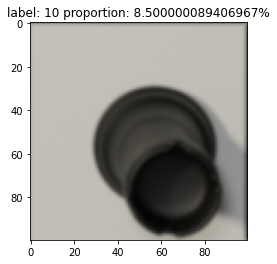

In [13]:
gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for plotting the metrics collected during training:

In [14]:
def plot_and_save_metrics(training_total_losses, training_coral_losses, gen_training_classification_losses, gen_training_accs, \
                           gen_training_f1s, gen_validation_accs, gen_validation_f1s, real_validation_accs, \
                              real_validation_f1s, validation_total_losses, validation_CORAL_losses, \
                                gen_validation_classification_losses, real_validation_classification_losses, \
                                  learning_rate, lambda_coral_max):
    
    validation_x_axis = np.arange(0, len(gen_validation_accs) * n_validation, n_validation)

    # Plot the training metrics
    plt.figure(figsize=(40, 40))

    plt.subplot(4, 2, 1)
    plt.plot(training_total_losses, label="Total loss")
    plt.plot(gen_training_classification_losses, label="Source domain classification loss")
    plt.title("Training total and classification losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 2, 2)
    plt.plot(gen_training_accs)
    plt.title("Training source domain accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.subplot(4, 2, 3)
    plt.plot(gen_training_f1s)
    plt.title("Training source domain weighted F1 score")
    plt.xlabel("Iteration")
    plt.ylabel("F1 score")

    # Plot the validation metrics
    plt.subplot(4, 2, 4)
    plt.plot(validation_x_axis, gen_validation_accs, label="Source domain")
    plt.plot(validation_x_axis, real_validation_accs, label="Target domain")
    plt.title("Validation accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(4, 2, 5)
    plt.plot(validation_x_axis, gen_validation_f1s, label="Source domain")
    plt.plot(validation_x_axis, real_validation_f1s, label="Target domain")
    plt.title("Validation weighted F1 scores")
    plt.xlabel("Iteration")
    plt.ylabel("F1 score")
    plt.legend()

    plt.subplot(4, 2, 6)
    plt.plot(validation_x_axis, validation_total_losses, label="Total loss")
    plt.plot(validation_x_axis, gen_validation_classification_losses, label="Source domain classification loss")
    plt.title("Validation total and source domain classification losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 2, 7)
    plt.plot(validation_x_axis, real_validation_classification_losses, label="Target domain classification loss")
    plt.plot(validation_x_axis, gen_validation_classification_losses, label="Source domain classification loss")
    plt.title("Validation source and target domain classification losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(4, 2, 8)
    plt.plot(training_coral_losses, label="Training")
    plt.plot(validation_x_axis, validation_CORAL_losses, label="Validation")
    plt.title("Training and validation CORAL losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.suptitle("Hyperparameters - learning rate: " + str(learning_rate) + ", lambda coral max: " + str(lambda_coral_max))

    plt.savefig("HP tuning results/" + "lr_" + str(learning_rate) + "_lambdacoralmax_" + str(lambda_coral_max) + ".png",  facecolor='white', transparent=False)
    plt.close()

We can now proceed to train our model:

In [15]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Learning rate", "Lambda max coral", "Final validation accuracy"])

for learning_rate in learning_rate_choices:

    for lambda_coral_max in lambda_max_coral_choices:

        # Define the data loaders accounting for the batch size
        gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size // 2)
        gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size // 2)
        gen_test_loader = get_gen_loader(test_gen_dataset, batch_size=batch_size // 2)
        real_train_loader = get_real_loader(train_real_dataset, batch_size=batch_size // 2)
        real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size // 2)
        real_test_loader = get_real_loader(test_real_dataset, batch_size=batch_size // 2)

        # Define the new loss function (Taking into account gamma)
        focal_loss = torch.hub.load(
            'adeelh/pytorch-multi-class-focal-loss',
            model='FocalLoss',
            gamma=gamma_focal_loss, # No use of alpha since we have balanced classes now with the oversampling
            reduction='mean',
            force_reload=False,
            verbose = False
        ).to(DEVICE)

        # To store the metrics through epochs
        training_total_losses = []
        training_CORAL_losses = []
        gen_training_classification_losses = []
        gen_training_accs = []
        gen_training_f1s = []
        gen_validation_accs = []
        gen_validation_f1s = []
        real_validation_accs = []
        real_validation_f1s = []
        validation_total_losses = []
        validation_CORAL_losses = []
        gen_validation_classification_losses = []
        real_validation_classification_losses = []

        # Define the model and the optimizer
        coralmodel = CoralModel().to(DEVICE)
        opt = optim.Adam(coralmodel.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs):
            
            # Train the model
            for iteration, ((X_train_gen, y_train_gen), (X_train_real, _)) in tqdm(enumerate(zip(gen_train_loader, real_train_loader))):
                
                # Set the model to training mode
                coralmodel.train()

                # Linear progress of the training (from 0 to 1)
                p = (epoch / num_epochs + iteration / len(real_train_loader) / num_epochs)
                lambda_coral = lambda_coral_max * p

                # Move the data to the device
                X_train_gen = X_train_gen.to(DEVICE)
                y_train_gen = y_train_gen.to(DEVICE)
                X_train_real = X_train_real.to(DEVICE)

                # Forward pass for source data (Generated data)
                hidden_rep_gen, y_train_pred_raw_gen = coralmodel(X_train_gen)
                y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

                # Forward pass for target data (Real data)
                hidden_rep_real, y_train_pred_raw_real = coralmodel(X_train_real)

                # Compute the classification loss (Focal loss)
                gen_classification_loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

                # Compute the domain loss (CORAL loss)
                coral_loss_train = (CORAL_loss(hidden_rep_gen, hidden_rep_real) + CORAL_loss(y_train_pred_raw_gen, y_train_pred_raw_real))

                # Get the total loss
                total_train_loss = gen_classification_loss_train + lambda_coral * coral_loss_train

                # Compute the accuracy
                gen_acc_train = accuracy(y_train_pred_gen, y_train_gen)
                gen_f1_train = f1_score(y_train_pred_gen, y_train_gen)

                # Backward pass
                opt.zero_grad()
                total_train_loss.backward()
                opt.step()

                # Store the training metrics
                training_total_losses.append(total_train_loss.item())
                training_CORAL_losses.append(coral_loss_train.item())
                gen_training_classification_losses.append(gen_classification_loss_train.item())
                gen_training_accs.append(gen_acc_train.item())
                gen_training_f1s.append(gen_f1_train.item())
                
                # Check if the model should be validated
                if iteration == 0 or (iteration + 1) % n_validation == 0:
                    
                    # Set the model to evaluation mode
                    coralmodel.eval()
                    
                    # Disable gradient calculation
                    with torch.no_grad():

                        # Initialize variables
                        gen_acc_val_sum = 0
                        real_acc_val_sum = 0
                        gen_weighted_f1_val_sum = 0
                        real_weighted_f1_val_sum = 0
                        gen_classification_loss_val_sum = 0
                        real_classification_loss_val_sum = 0
                        total_loss_val_sum = 0
                        coral_loss_val_sum = 0

                        # Extract an iterator from the data loaders
                        gen_val_iter = iter(gen_val_loader)
                        real_val_iter = iter(real_val_loader)

                        # Iterate for n_validation_minibatches
                        for i in range(n_validation_minibatches):

                            # Get the next minibatches
                            minibatch = next(gen_val_iter, None)
                            if minibatch is None:
                                gen_val_iter = iter(gen_val_loader)
                                minibatch = next(gen_val_iter)
                            X_val_gen, y_val_gen = minibatch

                            minibatch = next(real_val_iter, None)
                            if minibatch is None:
                                real_val_iter = iter(real_val_loader)
                                minibatch = next(real_val_iter)
                            X_val_real, y_val_real = minibatch
                                
                            # Move the data to the device
                            X_val_gen = X_val_gen.to(DEVICE)
                            y_val_gen = y_val_gen.to(DEVICE)
                            X_val_real = X_val_real.to(DEVICE)
                            y_val_real = y_val_real.to(DEVICE)

                            # Forward pass for source data (Generated data)
                            hidden_rep_gen, y_val_pred_raw_gen = coralmodel(X_val_gen)
                            y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                            # Forward pass for target data (Real data)
                            hidden_rep_real, y_val_pred_raw_real = coralmodel(X_val_real)
                            y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                            # Compute the metrics
                            gen_classification_loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen.long())
                            real_classification_loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real.long())
                            coral_loss_val_sum += (CORAL_loss(hidden_rep_gen, hidden_rep_real) + CORAL_loss(y_val_pred_raw_gen, y_val_pred_raw_real))
                            total_loss_val_sum += gen_classification_loss_val_sum + lambda_coral * coral_loss_val_sum # Only accounts for the generated classification loss as during training
                            gen_acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                            real_acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                            gen_weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                            real_weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)

                        # Compute the average metrics
                        gen_classification_loss_val = gen_classification_loss_val_sum / n_validation_minibatches
                        real_classification_loss_val = real_classification_loss_val_sum / n_validation_minibatches
                        coral_loss_val = coral_loss_val_sum / n_validation_minibatches
                        total_loss_val = total_loss_val_sum / n_validation_minibatches
                        gen_acc_val = gen_acc_val_sum / n_validation_minibatches
                        real_acc_val = real_acc_val_sum / n_validation_minibatches
                        gen_weighted_f1_val = gen_weighted_f1_val_sum / n_validation_minibatches
                        real_weighted_f1_val = real_weighted_f1_val_sum / n_validation_minibatches

                        # Store all metrics
                        gen_validation_classification_losses.append(gen_classification_loss_val.item())
                        real_validation_classification_losses.append(real_classification_loss_val.item())
                        validation_CORAL_losses.append(coral_loss_val.item())
                        validation_total_losses.append(total_loss_val.item())
                        gen_validation_accs.append(gen_acc_val.item())
                        real_validation_accs.append(real_acc_val.item())
                        gen_validation_f1s.append(gen_weighted_f1_val.item())
                        real_validation_f1s.append(real_weighted_f1_val.item())

                        # Print an update
                        clear_output(wait=True) # Only show the last print statement
                        print('----------------------------------------------------------------')
                        print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                        print(f'TRAINING => Total Loss: {total_train_loss}, CORAL Loss: {coral_loss_train}, Classification Loss (Gen): {gen_classification_loss_train}, Accuracy (Gen): {gen_acc_train}, Weighted F1 (Gen): {gen_f1_train}')
                        print(f'GENERATED VALIDATION => Classification Loss: {gen_classification_loss_val}, Validation accuracy: {gen_acc_val}, Validation weighted F1: {gen_weighted_f1_val}')
                        print(f'REAL VALIDATION => Classification Loss: {real_classification_loss_val}, Validation accuracy: {real_acc_val}, Validation weighted F1: {real_weighted_f1_val}')
                        print(f'SHARED VALIDATION => Total Loss: {total_loss_val}, CORAL Loss: {coral_loss_val}')
                        print('----------------------------------------------------------------')

            # Save the model every epoch as a checkpoint 
            torch.save(coralmodel.state_dict(), f'./checkpoints/coralmodel_lr_{learning_rate}_lambdacoralmax_{lambda_coral_max}.ckpt')

        # Evaluate the final real life validation accuracy

        # Set the model to evaluation mode
        coralmodel.eval()
        acc_val_sum = 0

        # Create an iterator
        real_val_iter = iter(real_val_loader)

        # Disable gradient calculation
        with torch.no_grad():
            
            for i in range(n_final_validation_minibatches):

                # Get the next minibatch
                minibatch = next(real_val_iter, None)
                if minibatch is None:
                    real_val_iter = iter(real_val_loader)
                    minibatch = next(real_val_iter, None)
                X_val_real, y_val_real = minibatch

                # Move the data to the device
                X_val_real = X_val_real.to(DEVICE)
                y_val_real = y_val_real.to(DEVICE)

                # Forward pass
                _, y_val_pred_prob_real = coralmodel(X_val_real)
                y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

                # Compute the metrics
                acc_val_sum += accuracy(y_val_pred_real, y_val_real)

        # Compute the average accuracy
        final_real_val_acc = acc_val_sum / n_final_validation_minibatches

        # Create a row to add to the dataframe
        row = [learning_rate, lambda_coral_max, final_real_val_acc.cpu().item()]

        # Store it
        hp_final_accs.loc[len(hp_final_accs)] = row

        # Compare to the best model
        if best_model is None or best_acc < final_real_val_acc:
            best_model = coralmodel
            best_acc = final_real_val_acc
            torch.save(coralmodel.state_dict(), f'./best_model.ckpt')

        # Plot and save the metrics
        plot_and_save_metrics(training_total_losses, training_CORAL_losses, \
                                gen_training_classification_losses, gen_training_accs, \
                                gen_training_f1s, gen_validation_accs, gen_validation_f1s, \
                                    real_validation_accs, real_validation_f1s, validation_total_losses, \
                                        validation_CORAL_losses, gen_validation_classification_losses, \
                                            real_validation_classification_losses, learning_rate, lambda_coral_max)
            
# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)


110it [01:44,  1.27s/it]

----------------------------------------------------------------
EPOCH [20], ITERATION [110]
TRAINING => Total Loss: 377224.4375, CORAL Loss: 3778.874755859375, Classification Loss (Gen): 5.8159098625183105, Accuracy (Gen): 0.05000000074505806, Weighted F1 (Gen): 0.004761904943734407
GENERATED VALIDATION => Classification Loss: 6.489011764526367, Validation accuracy: 0.08500000089406967, Validation weighted F1: 0.014297127723693848
REAL VALIDATION => Classification Loss: 6.310295104980469, Validation accuracy: 0.07999999821186066, Validation weighted F1: 0.012010632082819939
SHARED VALIDATION => Total Loss: 99702.3359375, CORAL Loss: 800.952880859375
----------------------------------------------------------------


113it [01:47,  1.06it/s]


After this code runs, the best model can be found in the directory of the script.